# Проект: классификация

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
import re
from sklearn.preprocessing  import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

### Произведем первичное исследование наших данных 
Посмотрим на признаки, изучим статистику по данным, проверим пропуски в данных.

In [3]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

В данной работе признаки обозначают следующие характеристики: 

Данные о клиентах банка:

-	**age** (возраст);

-	**job** (сфера занятости);

-	**marital** (семейное положение);

-	**education** (уровень образования);

-	**default** (имеется ли просроченный кредит);

-	**housing** (имеется ли кредит на жильё);

-	**loan** (имеется ли кредит на личные нужды);

-	**balance** (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

-	**contact** (тип контакта с клиентом);

-	**month** (месяц, в котором был последний контакт);

-	**day** (день, в который был последний контакт);

-	**duration** (продолжительность контакта в секундах).

Прочие признаки:

-	**campaign** (количество контактов с этим клиентом в течение текущей кампании);

-	**pdays** (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);

-	**previous** (количество контактов до текущей кампании)

-	**poutcome** (результат прошлой маркетинговой кампании).

Целевая переменная: 

- **deposit** - определяет, согласился ли клиент открыть депозит в банке


In [4]:
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [6]:
df.describe(exclude='object').T

,count,mean,std,min,25%,50%,75%,max
age,11162.0,41.231948,11.913369,18.0,32.0,39.0,49.00,95.0
day,11162.0,15.658036,8.420740,1.0,8.0,15.0,22.00,31.0
duration,11162.0,371.993818,347.128386,2.0,138.0,255.0,496.00,3881.0
campaign,11162.0,2.508421,2.722077,1.0,1.0,2.0,3.00,63.0
pdays,11162.0,51.330407,108.758282,-1.0,-1.0,-1.0,20.75,854.0
previous,11162.0,0.832557,2.292007,0.0,0.0,0.0,1.00,58.0


In [7]:
df.describe(exclude='number')

,job,marital,education,default,balance,housing,loan,contact,month,poutcome,deposit
count,11162,11162,11162,11162,11137,11162,11162,11162,11162,11162,11162
unique,12,3,4,2,3802,2,2,3,12,4,2
top,management,married,secondary,no,0 $,no,no,cellular,may,unknown,no
freq,2566,6351,5476,10994,774,5881,9702,8042,2824,8326,5873


Проведем проверку на явные пропуски в данных

In [8]:
df.isna().sum()[df.isna().sum() > 0]

balance    25
dtype: int64

### Задание 2

Касаемо явных пропусков все понятно. Теперь проверим на наличие неявных пропусков. Для этого проверим какие значения признаков имеются. Но, что важно, из списка категориальных признаков удалим признак balance. В исходном датасете он является категориальным, но позже приведем к его корректному классу - числовому. К тому же, мы и так увидили, что в данном признаке имеются пропуски.

In [9]:
object_feature_list = df.select_dtypes('object').columns.to_list()
object_feature_list.remove('balance')

for feature in object_feature_list:
    display(df[feature].value_counts())

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

marital
married     6351
single      3518
divorced    1293
Name: count, dtype: int64

education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64

default
no     10994
yes      168
Name: count, dtype: int64

housing
no     5881
yes    5281
Name: count, dtype: int64

loan
no     9702
yes    1460
Name: count, dtype: int64

contact
cellular     8042
unknown      2346
telephone     774
Name: count, dtype: int64

month
may    2824
aug    1519
jul    1514
jun    1222
nov     943
apr     923
feb     776
oct     392
jan     344
sep     319
mar     276
dec     110
Name: count, dtype: int64

poutcome
unknown    8326
failure    1228
success    1071
other       537
Name: count, dtype: int64

deposit
no     5873
yes    5289
Name: count, dtype: int64

Итак, 

в признаке **balance** мы имеем 25 явных пропуска. 

В признаке **job** мы имеем 70 неявных пропуска, с обозначением **unknown**.

В признаке **education** мы имеем 497 неявных пропуска, с обозначением **unknown**.

В признаке **contact** мы имеем 2346 неявных пропуска, с обозначением **unknown**.

В признаке **poutcome** мы имеем 8326 неявных пропуска, с обозначением **unknown** плюс 537 значений **other**.

### Задание 3

Теперь, как говорили ранее, преобразуем признак **balance**.

In [10]:
# Функция преобразования строкового значения баланса в числовой
def balance_convert(balance):
    """Function for converting string value of balance 
    with incorrect forms such as comma and dollar sign 
    to float number
    
    Try-except is using as there're data missings

    Args:
        balance (str): Frature value from DataFrame

    Returns:
        float: Float number of balance
    """
    
    try: 
        match = re.search(r'-?[\d\s,]+', balance)
        
        float_value = float(
            match.group().replace(' ', '').replace(',', '.')
        )
        
        return float_value
    
    except:
        
        return np.nan

# Преобразование значений признака
df['balance'] = df['balance'].apply(balance_convert)

### Задание 4

### Обработка пропусков

Обработаем пропуски следущим образом: 

Для числового признака **balance** заменим пропущенные значения на медианное.

Для категориальных признаков **job** и **education** заполним пропуски (наши "неявные" пропуски) модой признака.

In [11]:
# Обработка пропусков - заполнение медианным значением
df['balance'] = df['balance'].fillna(df['balance'].median())

### Задание 5

In [12]:
# Типововая обработка, "захватываем" нужные нам данные и меняем их
df.loc[df['job'] == 'unknown', 'job'] = df['job'].mode()[0]

df.loc[df['education'] == 'unknown', 'education'] = df['education'].mode()[0]

### Задание 6

### Обработка выбросов

Произведем обработку пропусков признака **balance** методом Тьюки. 

Для начала вычислим межвартильный размах (IQR), найдем границы распределения и затем удалим признаки, которые выпали из этого промежутка. 

In [13]:
# Вычисление IQR признака
iqr = df.balance.quantile(0.75) - df.balance.quantile(0.25)

# Расчитаем левую и правую границы
left_bound = df.balance.quantile(0.25) - 1.5*iqr
right_bound = df.balance.quantile(0.75) + 1.5*iqr

# Создадим список индексов к удалению (где значения "выпали" за границы)
indexes_to_drop = df[(df['balance'] < left_bound) | (df['balance'] > right_bound)].index

# Для расчета числа удаленных признаков зафиксируем начальный размер
origin_qnt = df.shape[0]

# Удалаем экземпляры по индексам
df = df.drop(index=indexes_to_drop, axis=1)

# Конечное число экземпляров данных, число удаленных
after_dropping_qnt = df.shape[0]
dropped_qnt = origin_qnt - after_dropping_qnt

print(f'Were dropped {dropped_qnt} raws')

Were dropped 1057 raws


## Часть 2:  Разведывательный анализ

### Задание 1

Разведывательный анализ начнем с изучения целевой переменной, чтобы узнать как распределены наши данные. Построим для этого визуализацию. А так же выведем текстовые данные по распределению значений признака. 

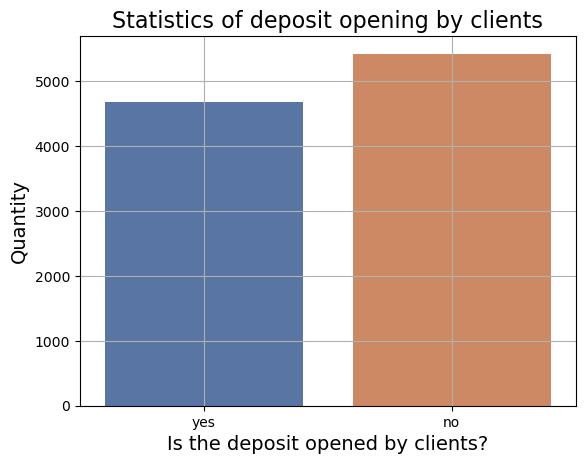

Quantity of clients who opend deposit = 4681, it's 46.32% of all clients
Quantity of clients who didn't open deposit = 5424, it's 53.68% of all clients


In [14]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
deposit_stat = sns.countplot(data=df, x='deposit', palette='deep')
deposit_stat.grid()
deposit_stat.set_title('Statistics of deposit opening by clients',
                       fontsize = 16)
deposit_stat.set_xlabel('Is the deposit opened by clients?',
                        fontsize = 14)
deposit_stat.set_ylabel('Quantity', fontsize = 14)

plt.show(deposit_stat)

opened_deposite_yes = df[df['deposit'] == 'yes']['deposit'].count()
opened_deposite_no = df[df['deposit'] == 'no']['deposit'].count()

opened_deposite_yes_ratio = (opened_deposite_yes / df.shape[0]) * 100
opened_deposite_no_ratio = (opened_deposite_no / df.shape[0]) * 100

print("Quantity of clients who opend deposit = {}, it's {:.2f}% of all clients".format(
    opened_deposite_yes, opened_deposite_yes_ratio
    ))

print("Quantity of clients who didn't open deposit = {}, it's {:.2f}% of all clients".format(
    opened_deposite_no, opened_deposite_no_ratio
    ))

По построенным диаграммам можно видеть, что значения распределены практически одинаково. Это хорошо для будущей модели машинного обучения.

### Задания 2 и 3

Для изучения влияния представленных числовых признаков на целевой признак построим диаграммы KDEplot. 

Причем построение будем вести следующим образом. В одних осях построим распределение признака тех, кто открыл депозит, тех, кто не открыл депозит, и суммарное распределение признака (просто линией).

Один из призаков - **day**, в той формулировке, что он присутствует, бессмысленный. Забежим немного вперед, в проектирование новых признаков, и создадим новый признак, который покажет на сколько давно с клиентом был контакт в рамках текущей кампании (опираясь на последний контакт из выборки). Назовем этот признак **since_last_call**. 

Так же создадим признак месяца как числовой признак, назовем его **month_num**. Очевидно, что он будет коррелировать с признаком **since_last_call**, но позволит "прочитать" данные с визуализации проще, а так же, возможно, натолкнет на какие-то соображаения. 

In [15]:
# Создадим признак в фрмате date-time format (Это вспомогательный признак)
df['day_month'] = pd.to_datetime(
    df['day'].astype('str').str.zfill(2) + '-' + df['month'].astype('str'), 
    format='%d-%b'
    )

# Последний контакт в рамках кампании
last_contact = df['day_month'].max()

# Создание признака "сколько дней назад был контакт"
df['since_last_call'] = df['day_month'].apply(lambda x: last_contact - x)
df['since_last_call'] = df['since_last_call'].astype('str').apply(
    lambda x: int(x.split(' ')[0]))

# Создание признака месяца в числовом формате
df['month_num'] = pd.to_datetime(df['month'], format='%b').dt.month

Приступим к визуализации. 

Создадим список категориальных признаков и построим диаграммы. 

In [16]:
# List of numeric feature 
num_cols = df.select_dtypes('number').columns.to_list()

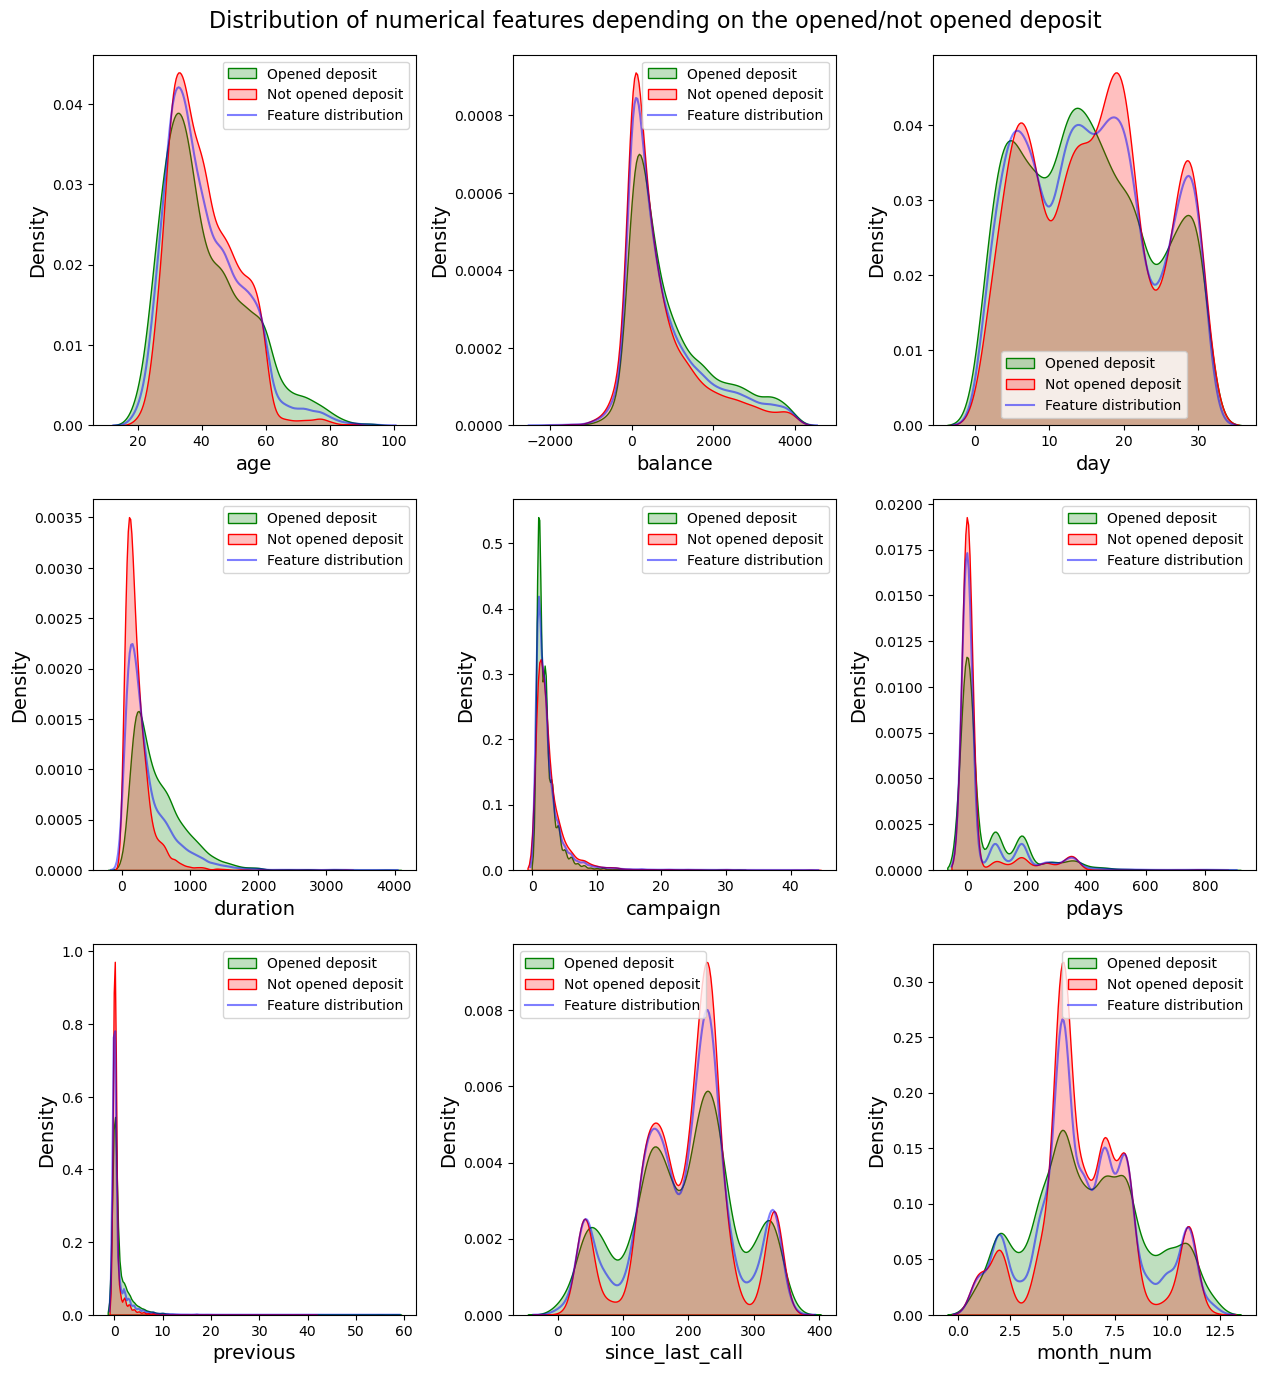

In [17]:
# making subplots for diagrams
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
plt.subplots_adjust(wspace=0.3, top=0.95)

# For loop - diagrams creating
for ax, feature in zip(axes.flat, num_cols):
    
    # Kde for clients who opend deposit
    kde_plot_yes = sns.kdeplot(
        df[df['deposit']=='yes'][feature], 
        label="Opened deposit", shade=True, color='green',
        ax=ax
    )
    
    # Kde for clients who haven't opend deposit
    kde_plot_no = sns.kdeplot(
        df[df['deposit']=='no'][feature], 
        label="Not opened deposit", shade=True, color='red',
        ax=ax
    )
    
    # Summary feature distribution
    kde_plot_no = sns.kdeplot(
        df[feature], 
        label="Feature distribution", shade=False, color='blue', alpha=0.5,
        ax=ax
    )
    
    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)
    
    kde_plot_yes.legend()    
    kde_plot_no.legend()

plt.suptitle('Distribution of numerical features depending on the opened/not opened deposit',
             fontsize=16);

Итак, по построенным диаграммам распределение мы можем сделать предварительные выводы и выдвинуть первые предположения, касаемо влияния различных признаков на целевой: 

- **Age** – большая часть распределения признаков в двух категориях дублирует друг друга, однако, видно небольшой перекос с возраста 60+ лет в сторону открывших депозит. 

- **Balance** – по построенным диаграммам складывается ощущение, что данный признак будет иметь слабую корреляцию с целевым признаком, хоть это и выглядит неожиданным. 

- **Day** – каких-то ощутимых различий не наблюдается.

- **Duration** – есть расхождения по группам. Видно, что в доле клиентов с бОльшей продолжительностью разговора увеличение количства клиентов, открывших депозит. Конечно, остается открытым вопрос, на сколько более продолжнительный контакт повлиял на решение, возможно, клиент и так имел желание / настрой на открытие депозита, а телефонный разговор бОльшей продолжительности – уточнение нюансов. 

- **Campaign** – интересное распределение, видно, что доля клиентов, открывших депозит имела небольшое количество контактов. Но, это отсылает как раз к рассуждению выше. У клиентов не открывших депозит наблюдается бОльшее количество контактов. В связи с этим возникает логичный вопрос о целесообразности большого количества звонков уже отказавшимся клиентам и расходования на это средств кампании. 

- **Pdays** – закономерностей (разницы в распределении) не прослеживается 

- **Previous** - закономерностей (разницы в распределении) не прослеживается

- **Since_last_call** и **month_num**  - рассмотрим оба этих признака вместе, ввиду упомянутой выше корреляции между собой. Здесь мы видим, что есть зависимости от сезона и открытия депозитов. Видно, что весной и осенью клиенты охотнее это делали. 


In [18]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код

### Задания 4 и 5

Теперь изучим распределение категориальных признаков. Изучение будем вести в разрезе целевого признака (открыл ли клиент депозит или нет)

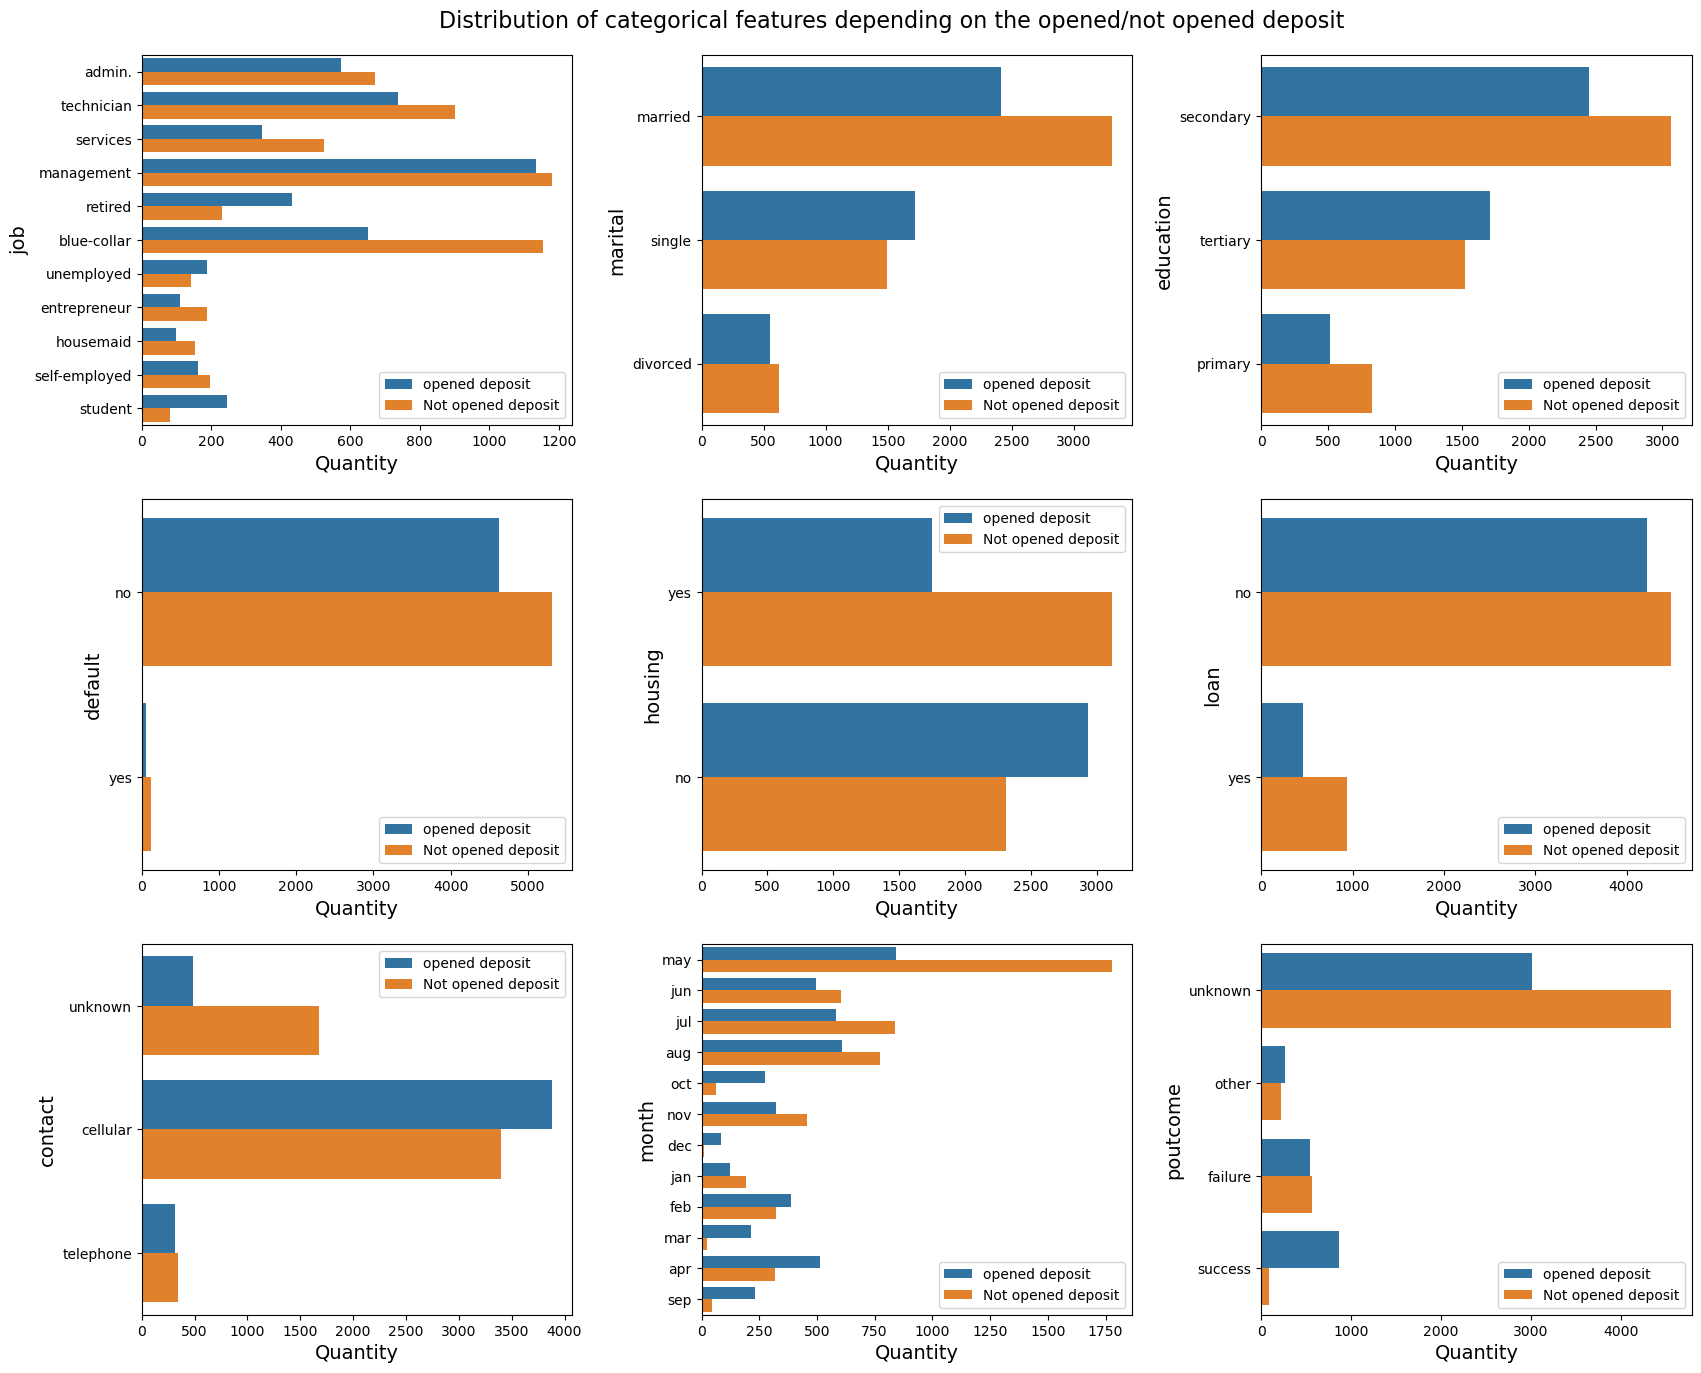

In [19]:
# Список категориальных признаков (сразу иисключаем срезом целевой признак)
cat_cols = df.select_dtypes('object').columns.to_list()[:-1]

# Зададим поле для графиков
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,15))
plt.subplots_adjust(wspace=0.3, top=0.95)

# Циклом For создадим диаграммы
for ax, feature in zip(axes.flat, cat_cols):
    
    countplot_feat = sns.countplot(data=df, y=feature, hue='deposit', ax=ax)
    
    countplot_feat.set_xlabel('Quantity')
    
    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)
    
    # new legend signs
    legend_labels = {'yes': 'opened deposit', 'no': 'Not opened deposit'}
    
    # getting legend
    handles, labels = ax.get_legend_handles_labels()
    
    # creating new legend signs
    new_labels = [legend_labels.get(label, label) for label in labels]
    
    # adjusting new legend
    ax.legend(handles=handles, labels=new_labels)
    
plt.suptitle('Distribution of categorical features depending on the opened/not opened deposit',
             fontsize=16);

В данных графиках наше внимание должны привлечь те признаки, в которых внутри одного значения категориального признака сильно отличаются значения количества клиентов, которые открыли депозит и тех, кто не открыл. 

- Признак **month** - является хорошим примером, как было и отмечено при построении зависимостей числовых признаков. В некоторые месяцы количество клиентов, открывших депозит больше тех, кто депозит не открыл. А в мае, например, не смотря на то, что суммарно в этот месяце открыли депозит наибольшее количество клиентов, отказавшихся - в два раза больше. И тут возникает вопрос о целесообразности финансовых тратах на кампанию в данном месяце, ведь именно относительный эффект не велик, более того, он наихудщий. 

- В принципе, почти во всех признаках есть такие значения, которые дают неравномерное распределение целевого признака. К менее информативным с данной точки зрения можно отнести признаки default, loan. 

- К признаку poutcome много вопросов. С одной стороны у него есть значение success, которое явно сигнализирует о высокой вероятности открытия клиентом депозита. С другой стороны, есть "равновесные" признаки, а так же огромное количетсво значений unknown. Хотя, в приницие, чем не значение, просто можно считать, что оно "обезличино". 


### Задание 6

Продемонстрируем полученные из визуализации выводы расчетно. 

Влияние результата клиента в прошлых маркетинговых кампаниях на текущую, учитываем те признаки, где открывших депозит больше, чем не открывших. 

In [20]:
# Сгруппируем нужные нам признаки, для вычисления путем вывода их в сводную таблицу
pivot_pout_dep = df.groupby(['poutcome', 'deposit']).size().unstack()

# "Обрежем" эту таблицу по заданным критериям
deposit_yes_more = pivot_pout_dep[
    pivot_pout_dep['yes'] > pivot_pout_dep['no']].index.to_list()

print('Для следующих категорий признака poutcome число открывших депозит больше, чем не открывших {}'.format(
    deposit_yes_more
))

Для следующих категорий признака poutcome число открывших депозит больше, чем не открывших ['other', 'success']


### Задание 7

Узнаем в каком месяце чаще всего отказывались открыть депозит. При этом, следуя формалировке "чаще" в данном случае мы будем считать относительную величину, отношение отказавшихся к общему числу клиентов, которым сделали предложение. 

In [21]:
pivot_month_dep = df.groupby(['month', 'deposit']).size().unstack()
pivot_month_dep['no_ratio'] = pivot_month_dep['no'] / (pivot_month_dep['yes'] + pivot_month_dep['no'])
worth_month_name = pivot_month_dep['no_ratio'].sort_values(ascending=False).index[0]
worth_month_value = (pivot_month_dep['no_ratio'].sort_values(ascending=False).values[0]*100).round()

print('В *{}* были чаще всего отказы, процент отказов от общего числа предложений: {} %'.format(
    worth_month_name, worth_month_value
    ))

В *may* были чаще всего отказы, процент отказов от общего числа предложений: 68.0 %


### Задание 8

Немного видоизменим признак возраста. Создадим новый признак **age_group**, разобъем клиентов по группам 0-30, 30-40, 40-50, 50-60, 60+ лет. И, определим какая из этих групп больше всех открыла депозит. Произведем и количественную, и качественную оценки. 

In [22]:
# Зададим границы возрастных групп
bins = [0, 30, 40, 50, 60, float('inf')]
# Зададим будущие названия групп
labels = ['<30', '30-40', '40-50', '50-60','60+']
# Создаем новый признак
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

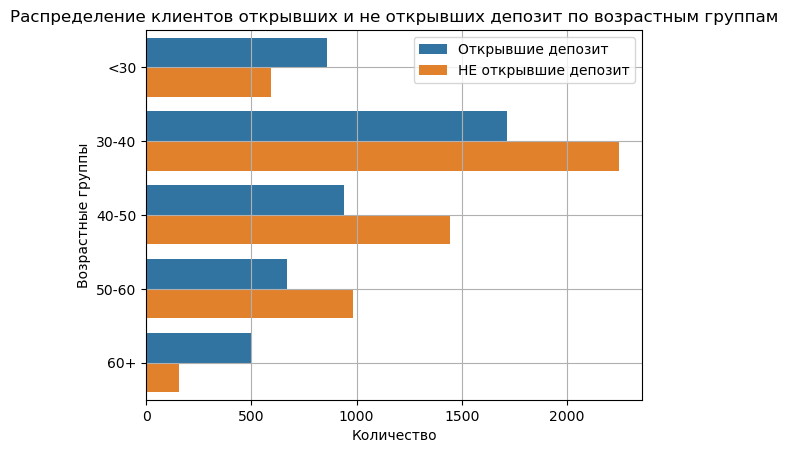

In [23]:
countplot_feat = sns.countplot(data=df, y='age_group', hue='deposit')

# new legend signs
legend_labels = {'yes': 'Открывшие депозит', 'no': 'НЕ открывшие депозит'}

# getting legend
handles, labels = ax.get_legend_handles_labels()

# creating new legend signs
new_labels = [legend_labels.get(label, label) for label in labels]

# adjusting new legend
countplot_feat.legend(handles=handles, labels=new_labels)
countplot_feat.set_xlabel('Количество')
countplot_feat.set_ylabel('Возрастные группы')
countplot_feat.set_title(
    'Распределение клиентов открывших и не открывших депозит по возрастным группам'
    )

countplot_feat.grid()

In [24]:
pivot_agegroup_deposit = df.groupby(['age_group', 'deposit']).size().unstack()

pivot_agegroup_deposit['no_ratio'] = round(
    pivot_agegroup_deposit['no']*100 / (pivot_agegroup_deposit['yes'] + pivot_agegroup_deposit['no']), 2
    )

pivot_agegroup_deposit['yes_ratio'] = round(
    pivot_agegroup_deposit['yes']*100 / (pivot_agegroup_deposit['yes'] + pivot_agegroup_deposit['no']), 2
    )

agegroup_most_openning = pivot_agegroup_deposit.sort_values(['yes_ratio'], ascending=False).index[0]

percantage_of_agegroup = round(
    df[df['age_group'] == agegroup_most_openning].count()[0]*100 / df.shape[0], 2
    )

print('В возрастной группе {} больше всего открывают депозит'.format(
    agegroup_most_openning
    ))

print('Данная возрастная группа составляет {} % от общего числа клиентов'.format(
    percantage_of_agegroup
    ))

В возрастной группе 60+ больше всего открывают депозит
Данная возрастная группа составляет 6.46 % от общего числа клиентов


Построим общую визуализацию по всем возрастным группам, демонстрирующую процент клиентов, которые открыли депозит. 

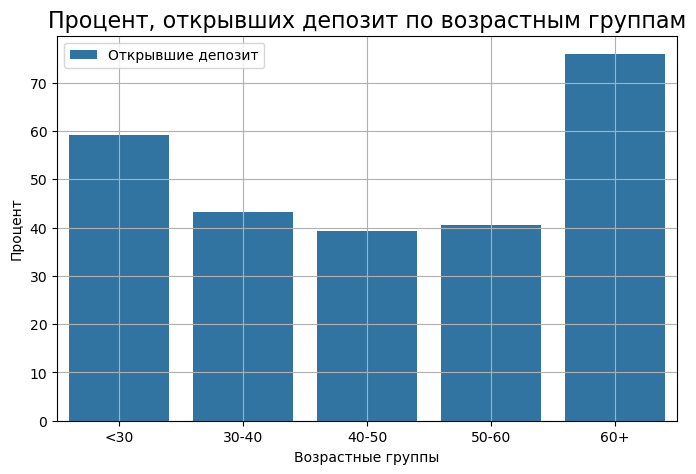

In [25]:
# Создадим новый ДФ, в котором перенесем индек - возрастную группу в отдельный признак
df_reset = pivot_agegroup_deposit.reset_index().rename(columns={'index': 'age_group'})

# Построим график
plt.figure(figsize=(8,5))

# Рисуем линии для каждого признака
sns.barplot(data=df_reset, x='age_group', y='yes_ratio',  label='Открывшие депозит')
# sns.barplot(data=df_reset, x='age_group', y='no_ratio',  label='Не открывшие депозит')

plt.xlabel('Возрастные группы')
plt.ylabel('Процент')
plt.title('Процент, открывших депозит по возрастным группам',
          fontsize = 16)
plt.legend()
plt.grid()
plt.show()

### Задания 9 и 10

Построим ряд визуализаций для демонстрации распределения открывших и не открывших депозит клиентов **в зависимости от**:


**семейного статуса**

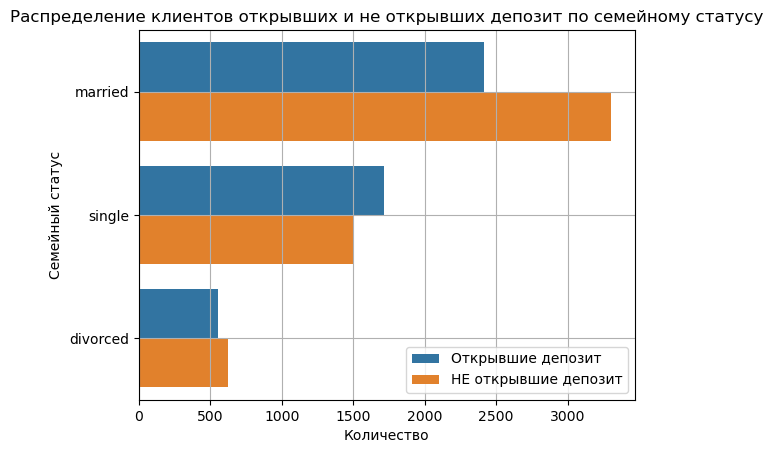

In [26]:
countplot_marital = sns.countplot(data=df, y='marital', hue='deposit')

# new legend signs
legend_labels = {'yes': 'Открывшие депозит', 'no': 'НЕ открывшие депозит'}

# getting legend
handles, labels = ax.get_legend_handles_labels()

# creating new legend signs
new_labels = [legend_labels.get(label, label) for label in labels]

# adjusting new legend
countplot_marital.legend(handles=handles, labels=new_labels)
countplot_marital.set_xlabel('Количество')
countplot_marital.set_ylabel('Семейный статус')
countplot_marital.set_title(
    'Распределение клиентов открывших и не открывших депозит по семейному статусу'
    )

countplot_marital.grid()

**уровня образования**

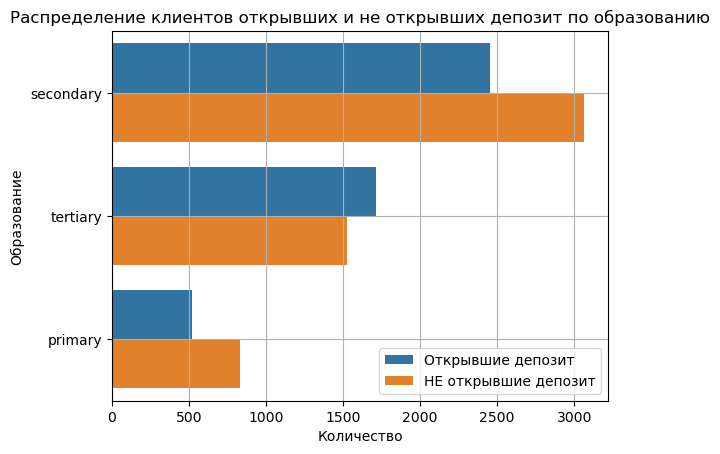

In [27]:
countplot_education = sns.countplot(data=df, y='education', hue='deposit')

# new legend signs
legend_labels = {'yes': 'Открывшие депозит', 'no': 'НЕ открывшие депозит'}

# getting legend
handles, labels = ax.get_legend_handles_labels()

# creating new legend signs
new_labels = [legend_labels.get(label, label) for label in labels]

# adjusting new legend
countplot_education.legend(handles=handles, labels=new_labels)
countplot_education.set_xlabel('Количество')
countplot_education.set_ylabel('Образование')
countplot_education.set_title(
    'Распределение клиентов открывших и не открывших депозит по образованию'
    )

countplot_education.grid()

**вида профессиональной деятельности**

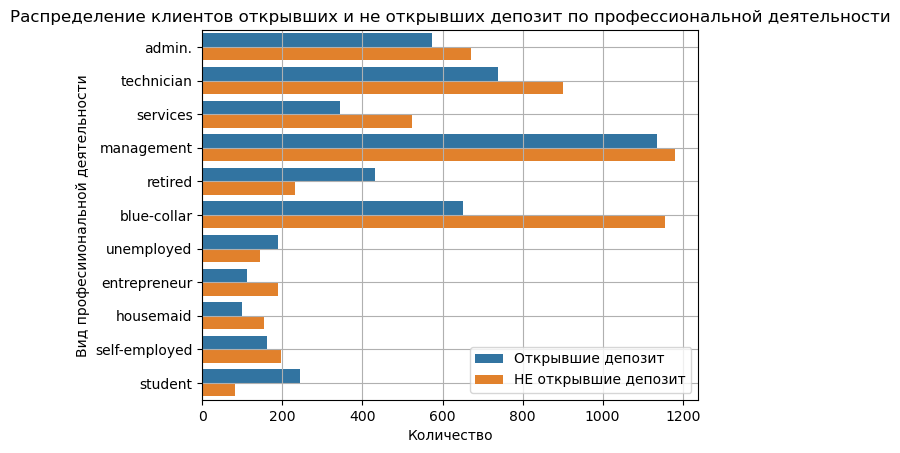

In [28]:
countplot_job = sns.countplot(data=df, y='job', hue='deposit')

# new legend signs
legend_labels = {'yes': 'Открывшие депозит', 'no': 'НЕ открывшие депозит'}

# getting legend
handles, labels = ax.get_legend_handles_labels()

# creating new legend signs
new_labels = [legend_labels.get(label, label) for label in labels]

# adjusting new legend
countplot_job.legend(handles=handles, labels=new_labels)
countplot_job.set_xlabel('Количество')
countplot_job.set_ylabel('Вид професииональной деятельности')
countplot_job.set_title(
    'Распределение клиентов открывших и не открывших депозит по профессиональной деятельности'
    )

countplot_job.grid()

### Задание 11

А теперь попробуем посмотреть влияние комбинаций признаков на целевое значение.

Сделаем это на примере двух признаков - **семейное положение (marital) и уровень образования (education)**.

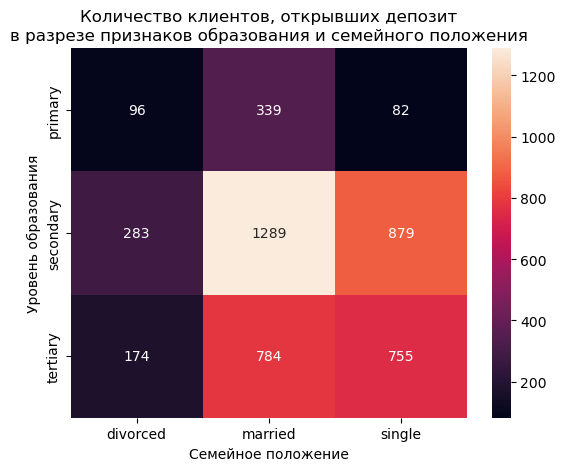

In [29]:
# Создаем сводную таблицу по интересущим признакам
edu_marital_dep_pivot = pd.pivot_table(
    data = df[df['deposit'] == 'yes'], 
    index = 'education', columns = 'marital', 
    values='deposit', aggfunc='count'
    )

# Создаем визуализацию - тепловую карту
edu_marital_dep_heatmap = \
    sns.heatmap(edu_marital_dep_pivot, fmt='.0f', annot=True)

# Добавляем наименований 
edu_marital_dep_heatmap.set_xlabel('Семейное положение')
edu_marital_dep_heatmap.set_ylabel('Уровень образования')    
edu_marital_dep_heatmap.set_title('Количество клиентов, открывших депозит' 
                                  '\n' + 'в разрезе признаков образования и семейного положения');

Мы видим, что самое большое число клиентов, открывших депозит относится к тем, кто состоит в браке, а так же имеет среднее образование. 

Однако, нам как всегда любопытна относительная оценка. Для этого построим такую же тепловую карту, но, в этот раз значения будут - не суммарное число клиентов, а доля открывших депозит клиентов от общего числа клиентов данной категории. 

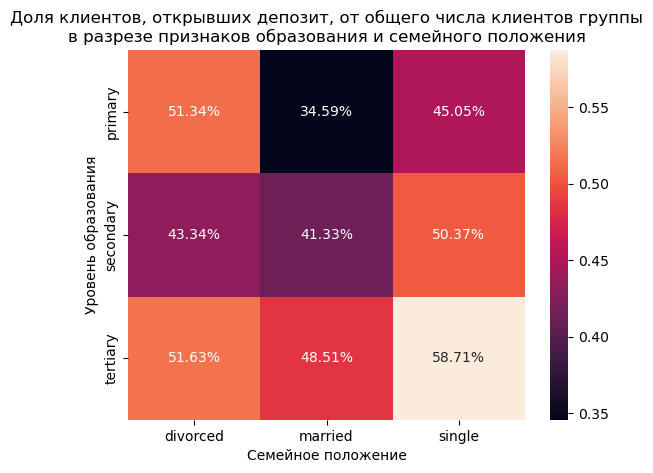

In [30]:
# Создаем кросстаб интересущих нас признаков
edu_marital_dep_crosstab = pd.crosstab([df['education'], df['marital']], df['deposit'])

# Создаем объект series с величиной долей
edu_marital_dep_ratio_alt = edu_marital_dep_crosstab['yes'] / edu_marital_dep_crosstab.sum(axis=1)

# Понижаем вложенность
edu_marital_dep_ratio_pivot = edu_marital_dep_ratio_alt.unstack()

# Строим тепловую карту
edu_marital_dep_ratio_heatmap = \
    sns.heatmap(edu_marital_dep_ratio_pivot, annot=True, fmt=".2%")

edu_marital_dep_ratio_heatmap.set_xlabel('Семейное положение')
edu_marital_dep_ratio_heatmap.set_ylabel('Уровень образования')    
edu_marital_dep_ratio_heatmap.set_title('Доля клиентов, открывших депозит, от общего числа клиентов группы' 
                                  '\n' + 'в разрезе признаков образования и семейного положения');

И тут мы видим уже абсолютно другую картину. Не смотря на скромные числовые показатели такой категории клиентов, как разведенные, в относительном выражении они обходят категорию клиентов, состоящих в браке (лидер "числовой" статистики), в плане открытия депозитов. 

А клиенты, не имевшие опыта состояния в брачных отношениях, среди всех трех групп, отличаются большим желанием открыть депозит.

Вероятно, данная информация будет полезна для будущих маркетинговых кампаний. 

## Часть 3: преобразование данных

### Задание 1

Начнем преобразование с признаков уровня образования и возрастной категории. Для этого используем кодирование меток (label encoding).

In [31]:
# Инициализируем объект - кодировщик
le = LabelEncoder()

# Произведем кодирование признака образование
df['education'] = le.fit_transform(df['education'])

# Произведем кодирование признака возрастной категории
df['age_group'] = le.fit_transform(df['age_group'])

### Задания 2 и 3

Так же у нас есть фактически бинарные признаки, значения которых всего два - **yes** и **no**. Произведем их кодировку в 1 и 0 соответственно. 

Список данных признаков - **default**, **housing**, **loan**, **deposit**.

In [32]:
# создадим список признаков для кодирования 
binary_list = ['default', 'housing', 'loan', 'deposit']

# Произведем кодирование в цикле for с применением лямбда-функции
for feature in binary_list:
    df[feature] = df[feature].apply(
        lambda x: 1 if x == 'yes' else 0
    )

### Задание 4

Теперь создадим дамми-признаки. Обработаем **job**, **marital**, **contact**, **month**, **poutcome**. При этом, исходные признаки мы пока удалять не будет, оставим их в датафрейме. 

In [33]:
# Список признаков на создание дамми
dummie_columns = ['job', 'marital', 'contact', 'month', 'poutcome']

# Создаем всмопогательный ДФ, куда определим кодируемые признаки
dummies_coding_feats = df[dummie_columns]

df = pd.get_dummies(df, columns=dummie_columns, 
                                  drop_first=False)

df = pd.concat([df, dummies_coding_feats], axis=1)

### Задания 5 и 6

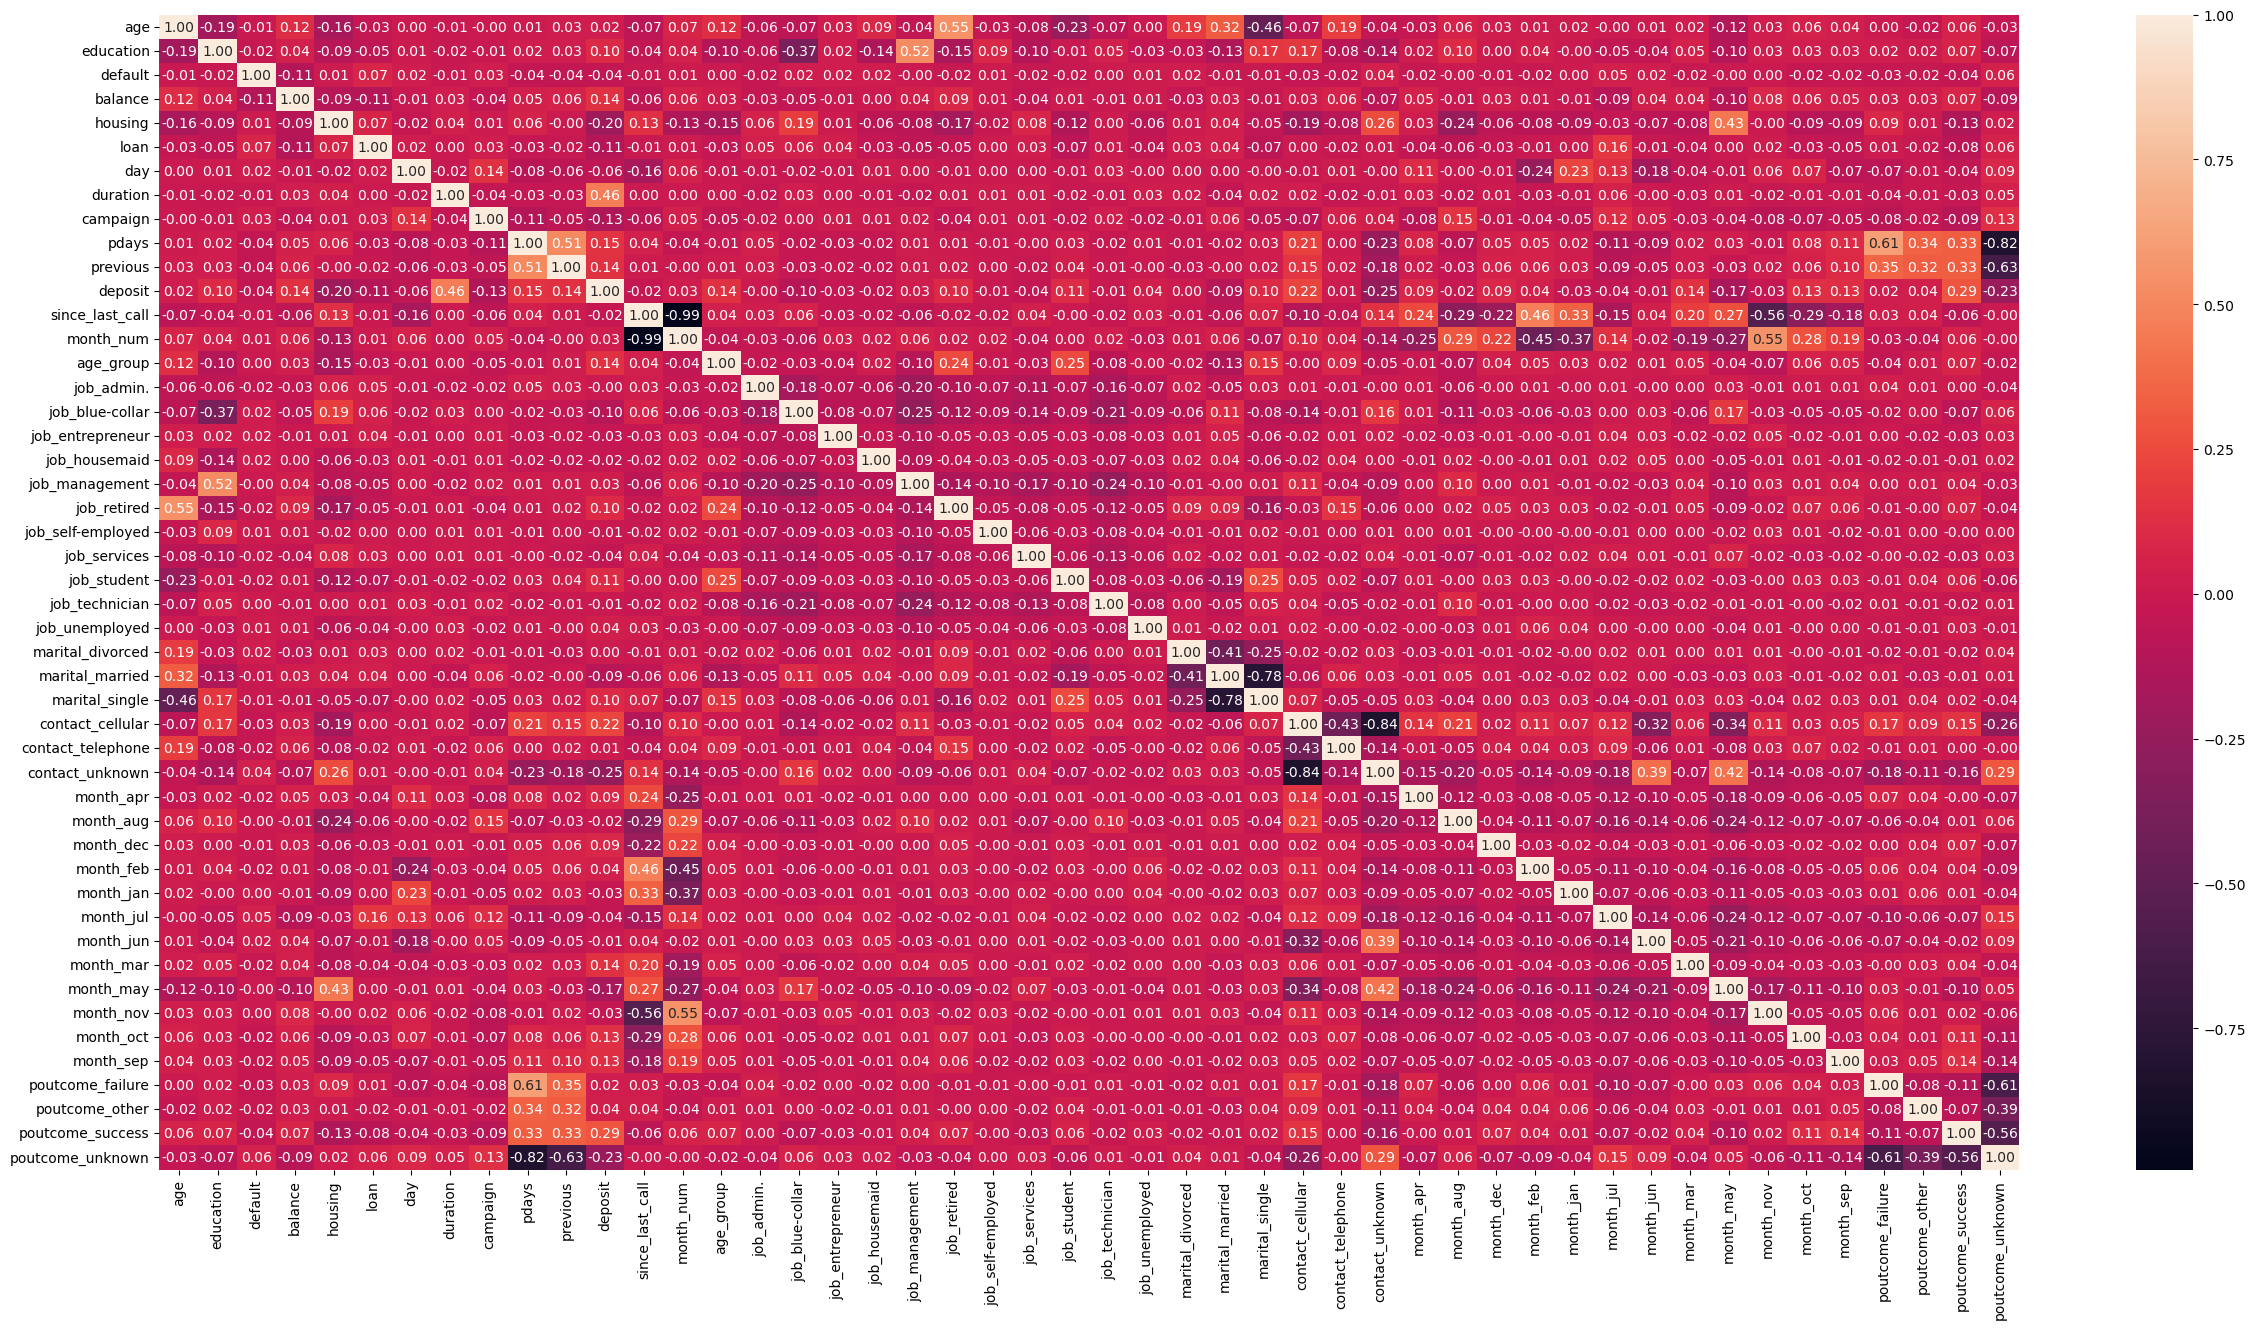

In [34]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(30,15))
sns.heatmap(corr_matrix, annot=True, fmt='.2f');

## ОПИСАТЬ

### Задания 7 и 8

In [35]:
# Создаем список категориальных признаков на удаление
cat_feature_to_drop = df.select_dtypes(include=['object']).columns.to_list()

# Создаем список признаков, которые создали ранее для визуализаций
created_features_list = ['since_last_call', 'month_num', 'day_month']
# Создаем ДФ с созданными для визуаилизаций признаками (мб пригодятся)
created_features_df = df[created_features_list]

# Общий список признаков на удаление
feats_to_drop_summary = cat_feature_to_drop + created_features_list

# Очищение ДФ от не числовых и созданных признаков
df = df.drop(feats_to_drop_summary, axis=1)

In [36]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state = 42, test_size = 0.33
    )

In [37]:
round(y.mean(), 2)

0.46

### Задание 9

Вввиду большого количества признаков, и, опираясь на ранее созданную матрицу корреляций, из которой мы знаем, что не все признаки имеют связь, достаточную для того, что считать их весомыми для целевого признака, произведем отбор признаков. 

Отбор будем производить при помощи метода SelectKBest с параметром score_func = f_classif, отберем 15 признаков.

In [40]:
# Создаем объект селектора признаков SelectKBest
selector = SelectKBest(score_func=f_classif, k=15)

# Обучим его на тренировочнй выборке
selector.fit(X_train, y_train)

SelectKBest(k=15)

In [ ]:
# Создадим список отобранных методом признаков
selected_features = selector.get_feature_names_out().tolist()

In [ ]:
# Обновим выборки с учетом выбранных селектором признаков
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

### Задание 10

Произведем теперь нормализацию данных. Воспользуемсся методом MinMaxScaller со стандартными параметрами. 

In [ ]:
# Создадим объект для нормализации данных
mm_scaller = MinMaxScaler()

# Обучим и применим нормализацию к тренировочной выборке
X_train_selected_scaled = mm_scaller.fit_transform(X_train_selected)

# Нормализуем данные тествовой выборке
X_test_selected_scaled = mm_scaller.transform(X_test_selected)

In [61]:
print('Среднее арифмитеческое первого стобца тестовой выборки = {}'.format(
    round(X_test_selected_scaled[:,0].mean(), 2))
      )

Среднее арифмитеческое первого стобца тестовой выборки = 0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [66]:
# обучите логистическую регрессию и рассчитайте метрики качества

lr_model = linear_model.LogisticRegression(
    solver='sag',
    max_iter=1000,
    random_state=42
    )

lr_model.fit(X_train_selected_scaled, y_train)

y_test_pred_lr = lr_model.predict(X_test_selected_scaled)

print('Модель обычной логистической регрессии: accuracy для тестовой выборки = {}'.format(
    round(metrics.accuracy_score(y_test, y_test_pred_lr), 3)
    ))

Модель обычной логистической регрессии: accuracy для тестовой выборки = 0.805


### Задания 2,3,4

In [67]:
# обучите решающие деревья, настройте максимальную глубину

dtc_model = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)

dtc_model.fit(X_train_selected_scaled, y_train)

y_train_pred_dtc = dtc_model.predict(X_train_selected_scaled)
y_test_pred_dtc = dtc_model.predict(X_test_selected_scaled)

print('Модель решающих деревьев: accuracy для тренировочной выборки = {}'.format(
    round(metrics.accuracy_score(y_train, y_train_pred_dtc), 3)
    ))

print('Модель решающих деревьев: accuracy для тестовой выборки = {}'.format(
    round(metrics.accuracy_score(y_test, y_test_pred_lr), 3)
    ))

Модель решающих деревьев: accuracy для тренировочной выборки = 1.0
Модель решающих деревьев: accuracy для тестовой выборки = 0.805


### Задание 5

In [79]:
# подберите оптимальные параметры с помощью gridsearch

param_grid_dtc = [{'max_depth': list(np.arange(1,20))}]

grid_search_dtc = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(criterion='entropy', random_state=42),
    param_grid=param_grid_dtc,
    n_jobs=-1
    )

grid_search_dtc.fit(X_train_selected_scaled, y_train)

y_test_pred_grid = grid_search_dtc.predict(X_test_selected_scaled)

print('Модель решающих деревьев с методом GreedSearchCV: accuracy для тестовой выборки = {}'.format(
    round(metrics.accuracy_score(y_test, y_test_pred_grid), 3)
    ))

print('Выбранная наилучшая глубина дерева составляет: {}'.format(
    grid_search_dtc.best_params_['max_depth']
))

Модель решающих деревьев с методом GreedSearchCV: accuracy для тестовой выборки = 0.81
Выбранная наилучшая глубина дерева составляет: 9


In [92]:
# подберите оптимальные параметры с помощью gridsearch

param_grid_dtc_2_params = {'max_depth': [3,5,7],
                           'min_samples_split': [2, 5, 7, 10]}

grid_search_dtc_2_params = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(criterion='entropy', random_state=42),
    param_grid=param_grid_dtc_2_params,
    n_jobs=-1
    )

grid_search_dtc_2_params.fit(X_train_selected_scaled, y_train)

y_test_pred_grid_2_params = grid_search_dtc_2_params.predict(X_test_selected_scaled)

print('Модель решающих деревьев с методом GreedSearchCV: f1-score для тестовой выборки = {}'.format(
    round(metrics.f1_score(y_test, y_test_pred_grid_2_params), 3)
    ))

print('Выбранная наилучшая глубина дерева составляет: {}, минимальное число образцов для разделения {}'.format(
    grid_search_dtc_2_params.best_params_['max_depth'], grid_search_dtc_2_params.best_params_['min_samples_split']
))

Модель решающих деревьев с методом GreedSearchCV: f1-score для тестовой выборки = 0.805
Выбранная наилучшая глубина дерева составляет: 7, минимальное число образцов для разделения 10


In [86]:
grid_search_dtc_2_params.best_params_

{'max_depth': 7}

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [100]:
# обучите на ваших данных случайный лес
rfc_model = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5, 
    max_depth=10,
    random_state=42
    )

rfc_model.fit(X_train_selected_scaled, y_train)

y_test_pred_rfc = rfc_model.predict(X_test_selected_scaled)

print('Метрика accuracy для тестовой выборки модели случайного леса: {}'.format(
    round(metrics.accuracy_score(y_test, y_test_pred_rfc), 2)
    ))

print('Метрика recall для тестовой выборки модели случайного леса: {}'.format(
    round(metrics.recall_score(y_test, y_test_pred_rfc), 2)
    ))

from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred_rfc))

Метрика accuracy для тестовой выборки модели случайного леса: 0.83
Метрика recall для тестовой выборки модели случайного леса: 0.83
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [99]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5, 
    max_depth=5, 
    random_state=42
    )

gb_model.fit(X_train_selected_scaled, y_train)

y_test_pred_gb = gb_model.predict(X_test_selected_scaled)

print('Метрика f1-score для тестовых данных модели градиентного бустинга: {}'.format(
    round(metrics.f1_score(y_test, y_test_pred_gb), 2)
))

Метрика f1-score для тестовых данных модели градиентного бустинга: 0.82


### Задание 4

In [105]:
# объедините уже известные вам алгоритмы с помощью стекинга 

stacking_estimators = [
    ('dtc', tree.DecisionTreeClassifier(
        criterion='entropy', random_state=42)),
    ('rfc', ensemble.RandomForestClassifier(
        n_estimators=100, criterion='gini',
        min_samples_leaf=5, max_depth=10,
        random_state=42)),
    ('gbc', GradientBoostingClassifier(
        learning_rate=0.05, n_estimators=300,
        min_samples_leaf=5, max_depth=5, 
        random_state=42))
    ]

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

stack_class_model = StackingClassifier(
    estimators=stacking_estimators,
    final_estimator=LogisticRegression(random_state=42)
)

stack_class_model.fit(X_train_selected_scaled, y_train)

y_test_pred_stack_class = stack_class_model.predict(X_test_selected_scaled)

print('Метрика precission для тестовой выборки стекинга: {}'.format(
    round(metrics.precision_score(y_test, y_test_pred_stack_class), 3)
))


Метрика precission для тестовой выборки стекинга: 0.803


### Задание 5

In [110]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
final_model = stack_class_model.final_estimator_

print(final_model.coef_)

[[-0.0957885   4.59932622  2.13313854]]


In [123]:
feature_importance = []

for name, model in stack_class_model.named_estimators_.items():
    if hasattr(model, "feature_importances_"):
        print(f"Важности признаков для {name}:")
        print(model.feature_importances_)
        feature_importance.append(model.feature_importances_)
    else:
        print(f"Модель {name} не поддерживает feature_importances_")

Важности признаков для dtc:
[0.19910153 0.02786354 0.41149187 0.05388078 0.03522469 0.02477076
 0.05007786 0.00860347 0.06386449 0.01624746 0.02040069 0.01209628
 0.00604478 0.06772024 0.00261154]
Важности признаков для rfc:
[0.04501441 0.04678364 0.52485724 0.02613541 0.05446909 0.02493688
 0.04733023 0.0258626  0.04346141 0.01953354 0.01712118 0.01360355
 0.00974556 0.07884258 0.02230269]
Важности признаков для gbc:
[5.97643550e-02 4.65833677e-02 5.01986860e-01 1.70947430e-02
 5.56996584e-02 8.87934303e-03 4.21077367e-02 4.60013696e-03
 7.37616775e-02 2.61442415e-02 1.45077474e-02 1.88237113e-02
 1.34275061e-02 1.16263701e-01 3.55214522e-04]


In [124]:
feature_importance

[array([0.19910153, 0.02786354, 0.41149187, 0.05388078, 0.03522469,
        0.02477076, 0.05007786, 0.00860347, 0.06386449, 0.01624746,
        0.02040069, 0.01209628, 0.00604478, 0.06772024, 0.00261154]),
 array([0.04501441, 0.04678364, 0.52485724, 0.02613541, 0.05446909,
        0.02493688, 0.04733023, 0.0258626 , 0.04346141, 0.01953354,
        0.01712118, 0.01360355, 0.00974556, 0.07884258, 0.02230269]),
 array([5.97643550e-02, 4.65833677e-02, 5.01986860e-01, 1.70947430e-02,
        5.56996584e-02, 8.87934303e-03, 4.21077367e-02, 4.60013696e-03,
        7.37616775e-02, 2.61442415e-02, 1.45077474e-02, 1.88237113e-02,
        1.34275061e-02, 1.16263701e-01, 3.55214522e-04])]

In [130]:
list(stack_class_model.named_estimators_.keys())

['dtc', 'rfc', 'gbc']

In [141]:
feature_importance_df = pd.DataFrame(
    feature_importance, columns=selected_features,
    index=list(stack_class_model.named_estimators_.keys()))

feature_importance_df_t = feature_importance_df.T

feature_importance_df_t.sort_values(by='rfc', ascending=False)

,dtc,rfc,gbc
duration,0.411492,0.524857,0.501987
poutcome_success,0.067720,0.078843,0.116264
pdays,0.035225,0.054469,0.055700
age_group,0.050078,0.047330,0.042108
housing,0.027864,0.046784,0.046583
balance,0.199102,0.045014,0.059764
contact_unknown,0.063864,0.043461,0.073762
campaign,0.053881,0.026135,0.017095
contact_cellular,0.008603,0.025863,0.004600
previous,0.024771,0.024937,0.008879


In [114]:
stack_class_model.named_estimators_['dtc'].

array([0.19910153, 0.02786354, 0.41149187, 0.05388078, 0.03522469,
       0.02477076, 0.05007786, 0.00860347, 0.06386449, 0.01624746,
       0.02040069, 0.01209628, 0.00604478, 0.06772024, 0.00261154])

In [120]:
feature_names = X_train_selected_scaled.columns if hasattr(X_train_selected_scaled, 'columns') else [f'feature_{i}' for i in range(X_train_selected_scaled.shape[1])]

for name, model in stack_class_model.named_estimators_.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        print(f"Важности признаков для модели {name}:")
        for fn, imp in zip(selected_features, importances):
            print(f"{fn}: {imp:.4f}")
    else:
        print(f"Модель {name} не поддерживает feature_importances_")

Важности признаков для модели dtc:
balance: 0.1991
housing: 0.0279
duration: 0.4115
campaign: 0.0539
pdays: 0.0352
previous: 0.0248
age_group: 0.0501
contact_cellular: 0.0086
contact_unknown: 0.0639
month_mar: 0.0162
month_may: 0.0204
month_oct: 0.0121
month_sep: 0.0060
poutcome_success: 0.0677
poutcome_unknown: 0.0026
Важности признаков для модели rfc:
balance: 0.0450
housing: 0.0468
duration: 0.5249
campaign: 0.0261
pdays: 0.0545
previous: 0.0249
age_group: 0.0473
contact_cellular: 0.0259
contact_unknown: 0.0435
month_mar: 0.0195
month_may: 0.0171
month_oct: 0.0136
month_sep: 0.0097
poutcome_success: 0.0788
poutcome_unknown: 0.0223
Важности признаков для модели gbc:
balance: 0.0598
housing: 0.0466
duration: 0.5020
campaign: 0.0171
pdays: 0.0557
previous: 0.0089
age_group: 0.0421
contact_cellular: 0.0046
contact_unknown: 0.0738
month_mar: 0.0261
month_may: 0.0145
month_oct: 0.0188
month_sep: 0.0134
poutcome_success: 0.1163
poutcome_unknown: 0.0004


In [119]:
selected_features

['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_group',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

### Задания 6,7,8

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna